## Preambule

In [11]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Parameter

In [12]:
hist_startyear = 1990

## Paths

In [13]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = path_main / "Data" / str(hist_startyear)
path_figs = path_main / "Figures"

## Read data files

In [14]:
xr_total = xr.open_dataset(path_data / "xr_total.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
only_regions_iso = ['CVF', 'G20', "EU", "G7", "NA", "AU", "AF", "SIDS", "LDC", "WORLD"]
only_regions_names = ['Climate Vulnerability Forum','G20',"European Union","G7","Northern America","Australasia","African Group","Small Island Developing States","Least Developed Countries"]

In [15]:
xr_budgets_static = xr.open_dataset(path_data / "xr_budgets_static.nc")
xr_budgets_linear = xr.open_dataset(path_data / "xr_budgets_linear.nc")
xr_budgets_scenario = xr.open_dataset(path_data / "xr_budgets_scenario.nc")
df_michel = pd.read_excel(Path("X:/user/dekkerm/Data/") / "NDC" / "NDC_comparison.xlsx", sheet_name="Michel")

## Preprocess

In [16]:
ndc_deviations = []
for c_i, c in enumerate(["C1", "C3", "C5"]):
    li = []
    for a_i, approach in enumerate(["GF", "PC", "PCC"]):
        li.append([float((xr_budgets_scenario.sel(Ccat = c, Variable = approach, Region=r, Time=2030).Value - ((xr_total.NDC_l.sel(Time=2030, ISO=r)+xr_total.NDC_h.sel(Time=2030, ISO=r))/2)) / ((xr_total.NDC_l.sel(Time=2030, ISO=r)+xr_total.NDC_h.sel(Time=2030, ISO=r))/2)) for r in xr_budgets_scenario.Region])
    ndc_deviations.append(li)

## Plot

In [29]:
all_regions_iso

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS',
       'AUT', 'AZE', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN',
       'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR', 'BFA', 'BDI',
       'KHM', 'CMR', 'CAN', 'CPV', 'CAF', 'TCD', 'CHL', 'CHN', 'COL',
       'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE',
       'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ',
       'ERI', 'EST', 'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GAB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KIR', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU',
       'LUX', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL',
       'MRT', 'MUS', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MAR',
       'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NZL', 'NIC', 'NER',
       'NGA', 'NIU',

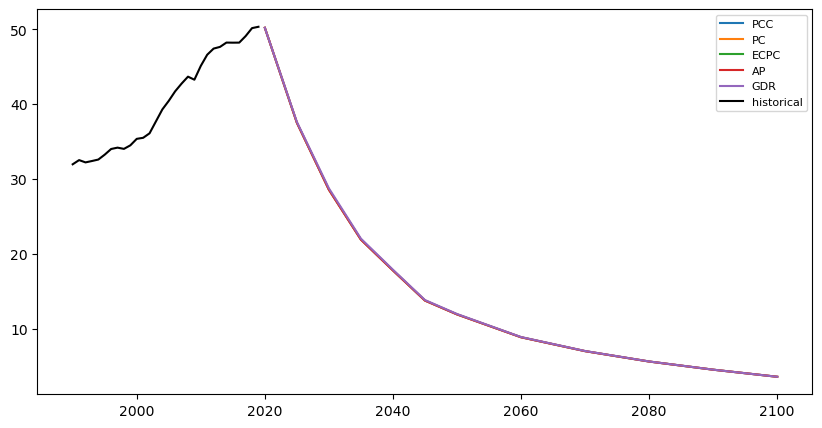

In [28]:
reg = "WORLD"
ccat = 'C1'
fig, ax = plt.subplots(figsize=(10, 5))
#plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='A2_trans').Value, label='A2_trans')
#plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='A2_gdp_net').Value, label='App2_gdp_net')
#plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='GF').Value, label='GF')
plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='PCC').Value, label='PCC')
plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='PC').Value, label='PC')
plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='ECPC').Value, label='ECPC')
plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='AP').Value, label='AP')
plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='GDR').Value, label='GDR')
#plt.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Ccat=ccat, Region=reg, Variable='BR').Value, label='BR')
#plt.plot(xr_total.Time, xr_total.GHG_base.sel(ISO=reg), label='base')
plt.plot(xr_total.Time, xr_total.GHG_p.sel(ISO=reg), 'k', label='historical')
#plt.plot(self.xr_total.Time, self.xr_total.GHG_base.sel(ISO=reg)-self.xr_total.GHG_f.sel(Category=ccat), label='base')
#plt.plot(self.xr_budgets_scenario.Time, gdr[:, -1, 0])
plt.legend(fontsize=8)

In [18]:
fig = make_subplots(rows=3, cols=3, subplot_titles=('Grandfathering (GF)','Per Capita (PC)', 'Per Capita Convergence (PCC)'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                                    horizontal_spacing = 0.005, vertical_spacing=0.005, shared_xaxes=True)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for c_i, c in enumerate(["C1", "C3", "C5"]):
    for a_i, approach in enumerate(["GF", "PC", "PCC"]):
        if c_i == 0 and a_i == 0:
            cm= True
        else:
            cm= False
        fig.add_trace(
            go.Choropleth(
            locations=xr_budgets_scenario.Region,
            z = ndc_deviations[c_i][a_i],
            locationmode = 'ISO-3',
            colorscale = 'RdYlGn',
            zmax = 1,
            zmin = -1,
            text = [str(r)+": "+str(np.round(float(ndc_deviations[c_i][a_i][r_i])*100, 2))+"%" for r_i, r in enumerate(np.array(xr_budgets_scenario.Region))],
            hovertemplate  = '%{text}',
            name="",
            colorbar=dict(len=1, x=1, tickvals = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], ticktext = ["-100%", "-75", "-50%", "-25%", "0%", "+25%", "+50%", "+75%", "+100%"], title={"text":"Budget<br>compared<br>to NDC"}),
            showscale=cm
        ), 1+c_i, a_i+1)
fig.update_geos(showocean=True, oceancolor="ghostwhite")
fig.update_geos(showlakes=True, lakecolor="ghostwhite")


for t_i, t in enumerate(['C1: below 1.5 degrees (>50%)', 'C3: below 2 degrees (>67%)', 'C5: below 2.5 degrees (>50%)']):
    fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False,
                       y=0.95-0.45*t_i,
                       x=-0.02, 
                       textangle=-90,
                       text=t,
                       font=dict(color='black', size=16),
                    )
                    
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False,
                    y=0.7,
                    x=1.02, 
                    textangle=90,
                    text="NDC ambitious enough <<<",
                    font=dict(color='black', size=16),
                )
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False,
                    y=0.2,
                    x=1.02, 
                    textangle=90,
                    text=">>> NDC not ambitious enough",
                    font=dict(color='black', size=16),
                )
#fig.update_traces(showscale=False)
fig.update_layout(height=1200, width=2200)

In [19]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_NDCperf/Figure_NDCperf.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_NDCperf/Figure_NDCperf.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_NDCperf/Figure_NDCperf.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_NDCperf/Figure_NDCperf.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))